In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Context

Имеется синтетический набор данных, используемый для этого соревнования. Он основан на реальном наборе данных (в данном случае, фактических данных Titanic) и сгенерирован с использованием CTGAN. Статистические свойства этого набора данных очень похожи на свойства оригинального набора данных.

Загружаем датасет и приступаем к описанию данных.

In [88]:
df_path = 'train.csv'
df = pd.read_csv(df_path, index_col = 'PassengerId')
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


## Описание переменных
### PassengerId:
Номер пассажира 
### Survived:  
0 = не выжил, 1 = выжил
### PClass:
1 - й = VIP  
2 - й = Комфорт  
3 - й = Эконом
### Name:  
Имя пассажира
### Sex:  
Пол
### Age:  
Возраст дробный, если меньше 1. Если возраст оценивается, то в форме xx.5
### Sibsp: 
Количество близких родственников на борту. Тип родства для столбца **Sibsp** определяется как:    
Родной брат = брат, сестра, сводный брат, сводная сестра  
Супруг = муж, жена (любовницы и женихи были не в счет)
### Parch: 
Количество детей или родитилей на борту. Тип родства для столбца **Parch** определяется как: 
Родитель = мать, отец  
Ребенок = дочь, сын, падчерица, пасынок  
Некоторые дети путешествовали только с няней, поэтому **parch**=0 для них.
### Tiket:
Номер билета
### Fare:
Стоимость входного билета
### Cabin:
Номер каюты
### Embarked:
Порт посадки   
S = Southampton (England),   
C = Cherbourg (France),  
Q = Queenstown (Ireland)

# Data quality assessment

### Проводим оценку полноты информации, представленной в датасете.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [243]:
# Определение количества отсутствующих значений и степень полноты данных
NA_count = df.isna().sum()
completeness_ratio = df.count() / df.shape[0]
print(f'{NA_count} \n\n{completeness_ratio}')

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket       4623
Fare            0
Cabin       67866
Embarked        0
dtype: int64 

Survived    1.00000
Pclass      1.00000
Name        1.00000
Sex         1.00000
Age         1.00000
SibSp       1.00000
Parch       1.00000
Ticket      0.95377
Fare        1.00000
Cabin       0.32134
Embarked    1.00000
dtype: float64


### Вывод
Для столбцов **Age, Ticket, Fare, Cabin, Embarked** есть отсутствующие значения.  
В столбце **Cabin** отсутствует около ***68%*** значений. Для остальных стобцов количество отсутствующих значений не превышает ***5%***. 

### Замена значений NaN для столбцов Age, Fare, Embarked.

In [157]:
# Замена значений NaN для столбца Age в зависимости от Pclass и Sex. Замену производим по значению моды.
for i in sorted(df['Pclass'].unique()):
    for j in ['male' , 'female']:
        mask = (df['Pclass'] == i) & (df['Sex'] == j) & (df['Age'].notna() == False)
        passenger_class = df[(df['Pclass'] == i) 
                             & (df['Sex'] == j) 
                             & (df['Age'].notna() == True)]['Age'].mode()[0]
        df['Age'].where(~(mask), other=passenger_class, inplace=True)

#Замена значений NaN для столбца Fare в зависимости от Pclass. Замену производим по среднему значению.
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.mean()))

#Замена значений NaN для столбца Embarked. Замену произведем по значению моды.
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

#### Проверка на предмет заполненных полей после замены NaN

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       100000 non-null  float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      100000 non-null  float64
 9   Cabin     32134 non-null   object 
 10  Embarked  100000 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 11.2+ MB


В датафрейме осталось 2 столбца, содержащих NaN - **Ticket** и **Сabin**.  
Принято решение оставить эти столбцы в наборе данных без изменений. Позже можно провести локальное исследование с учётом особых условий.

# Data exploration

### В начале оценим насколько значения датафрейма коррелируют между собой. 
Таким образом отбираем пары потенциальных признаков, исследование которых может оказаться интересным.

<AxesSubplot:title={'center':'Корреляционная карта параметров'}>

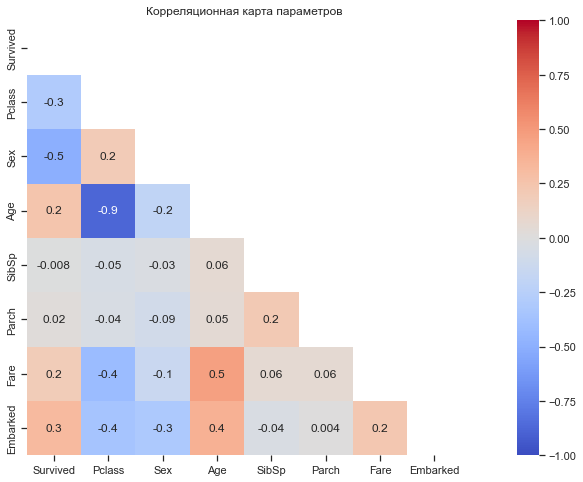

In [242]:
df_w_nums = df.copy()

# Проведем замену значений столбцов со строками (Sex, Embarked) на числовые значения.
df_w_nums['Sex'] = df_w_nums['Sex'].replace(to_replace=['male','female'], value=[1,0])
df_w_nums['Embarked'] = df_w_nums['Embarked'].replace(to_replace=['S','C','Q'], value=[0,1,2])

df_corr = np.triu(df_w_nums.corr())

# Строим корреляционную карту
plt.figure(figsize = (20,8))
plt.title('Корреляционная карта параметров')
sns.heatmap(df_w_nums.corr(), annot = True, 
            vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', 
            mask=df_corr, fmt = '.1g', square=True)

In [238]:
# Список пар с силой корреляции выше 0.4
most_correlated_pairs = df_w_nums.corr().unstack()
most_correlated_pairs[(most_correlated_pairs != 1.0) &
                      (abs(most_correlated_pairs) > 0.4)].drop_duplicates(keep='first', inplace=False).index.to_list()

[('Survived', 'Sex'), ('Pclass', 'Age'), ('Pclass', 'Fare'), ('Age', 'Fare')]

### Вывод:
Список коррелирующих пар признаков (в порядке убывания силы):  
- Age - Pclass;
- Fare - Age;  
- Sex - Survived;
- Fare - Pclass;
- Embarked/Fare - Age

<Figure size 1440x576 with 0 Axes>

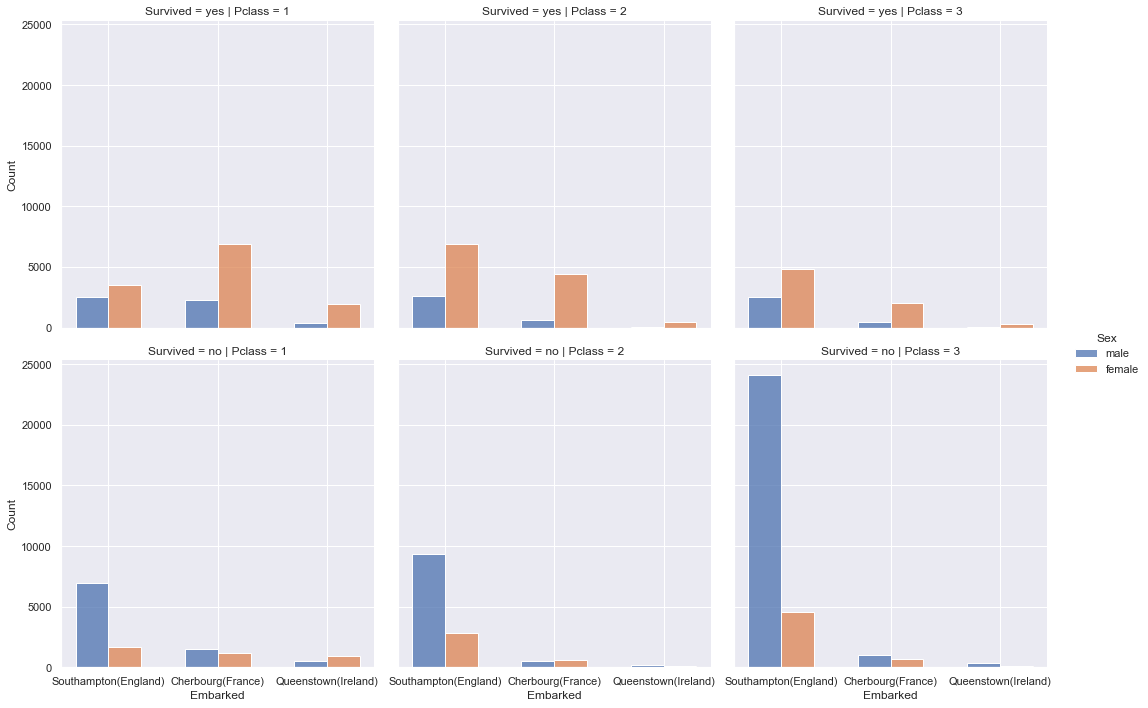

In [291]:
df1 = df.copy()

# Проводим замену значений столбцов (Survived, Embarked) на строковые значения.
df1['Survived'] = df1['Survived'].replace(to_replace=[1, 0], value=['yes','no'])
df1['Embarked'] = df1['Embarked'].replace(to_replace=['S', 'C', 'Q'], 
                                          value=['Southampton(England)','Cherbourg(France)', 'Queenstown(Ireland)'])

# 
plt.figure(figsize=(20,8))
sns.set_theme(style="darkgrid")
sns.displot(data=df1, x='Embarked', col='Pclass', row='Survived', 
            hue='Sex', multiple='dodge', 
            shrink = 0.6)

# Summary

### Выводы:
1) Большее число погибших путешевствовали в 3-ем классе.  
2) Требование капитана корабля по спасению женщин, в целом выполнялось. Наибольшая доля погибших женщин пришлась на пассажиров 3-го класса.  
3) Пассажиры, севшие на борт Титаника в Ирландии, в основном находились в 1-ом классе.